In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Motivating GMM: Weakness of k-Means

In [10]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, 
                      cluster_std=0.6, random_state=0)
X = X[:, ::-1] # flipping axes for better plotting


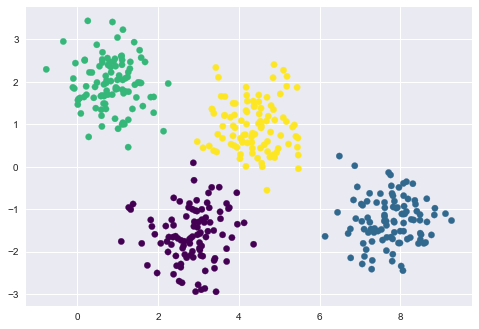

In [11]:
# plot the data with K-means labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');


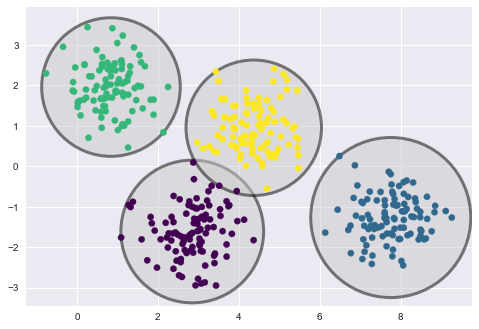

In [38]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_cluster=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2);
    
    # plot the circle for the kmeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, edgecolor='k', 
                                alpha=0.5, zorder=1))
        
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

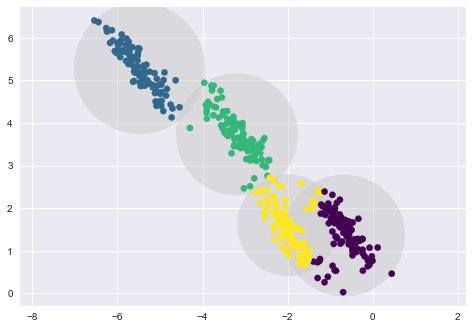

In [37]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

These two disadvantages of k-means—its lack of flexibility in cluster shape and lack
of probabilistic cluster assignment—mean that for many datasets (especially lowdimensional
datasets) it may not perform as well as you might hope.

### Generalizing the E-M: Gaussian Mixture Models
A Gaussian mixture model (GMM) attempts to find a mixture of multidimensional
Gaussian probability distributions that best model any input dataset.

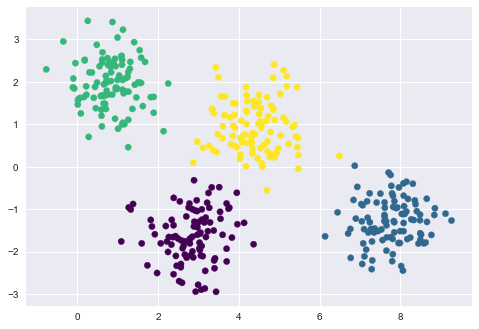

In [42]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [43]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[ 0.     0.463  0.     0.537]
 [ 1.     0.     0.     0.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.     0.     0.     1.   ]
 [ 1.     0.     0.     0.   ]]


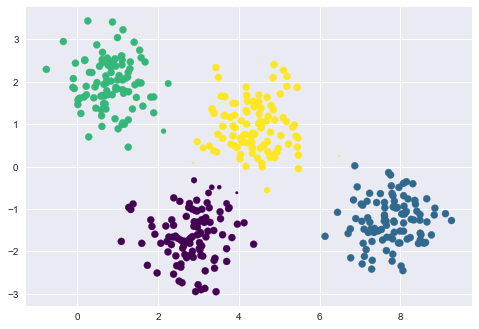

In [47]:
# visualizing the uncertainty by making it proportional to the size
size = 50 * probs.max(1) ** 5 # square to k=empahasize tdifferences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an
expectation–maximization approach that qualitatively does the following:
1. Choose starting guesses for the location and shape
2. Repeat until converged:
    - E-step: for each point, find weights encoding the probability of membership in
each cluster
    - M-step: for each cluster, update its location, normalization, and shape based
on all data points, making use of the weights

Let’s create a function that will help us visualize the locations and shapes of the GMM
clusters by drawing ellipses based on the gmm output

In [60]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given psition and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
    angle, **kwargs))
    
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

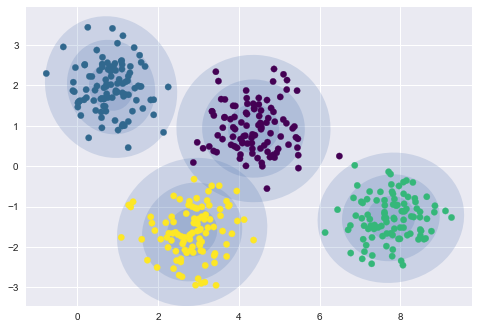

In [62]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)


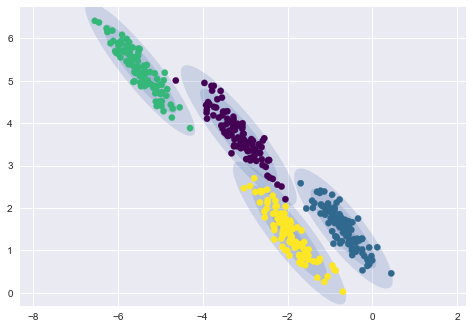

In [63]:
# using GMM for the stretched data
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

The hyperparameter controls the degrees of freedom in the shape of each cluster is the covariance type


### GMM as Density Estimation
Though GMM is often categorized as a clustering algorithm, fundamentally it is an
algorithm for density estimation. That is to say, the result of a GMM fit to some data is
technically not a clustering model, but a generative probabilistic model describing the
distribution of the data.

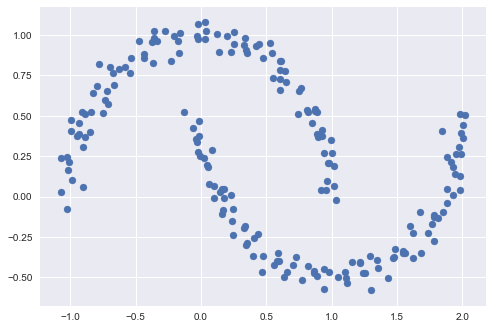

In [66]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

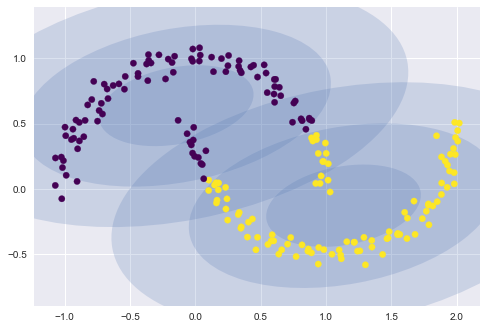

In [67]:
#If we try to fit this to a two-component GMM viewed as a clustering model,
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

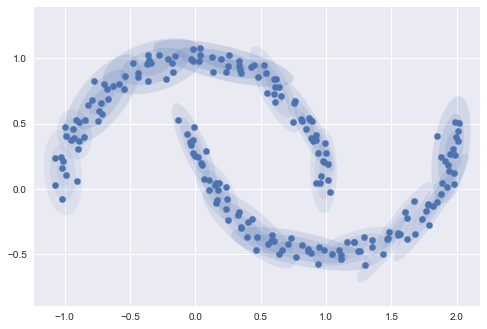

In [70]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=1)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but
rather to model the overall distribution of the input data. This is a generative model of
the distribution, meaning that the GMM gives us the recipe to generate new random
data distributed similarly to our input. For example, here are 400 new points drawn
from this 16-component GMM fit to our original datam

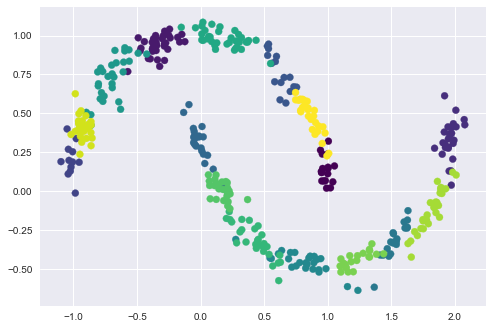

In [80]:
Xnew, y = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=y, cmap='viridis');

#### How many components
A generative model is inherently
a probability distribution for the dataset, and so we can simply evaluate the likelihood
of the data under the model, using cross-validation to avoid overfitting. Another
means of correcting for overfitting is to adjust the model likelihoods using some analytic
criterion such as the Akaike information criterion (AIC) or the Bayesian information
criterion (BIC). Scikit-Learn’s GMM estimator actually includes built-in
methods that compute both of these, and so it is very easy to operate on this
approach.

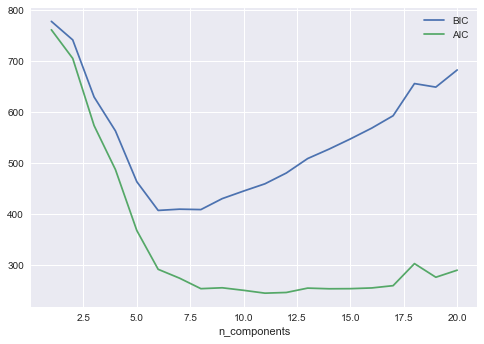

In [81]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
         for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

The optimal number of clusters is the value that minimizes the AIC or BIC, depending
on which approximation we wish to use.

Notice the important point: this choice of number of components measures how well
GMM works as a density estimator, not how well it works as a clustering algorithm. I’d
encourage you to think of GMM primarily as a density estimator, and use it for clustering
only when warranted within simple datasets

### Example: GMM for Generating New Data
Here we will run
with this idea and generate new handwritten digits from the standard digits corpus
that we have used before

In [86]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

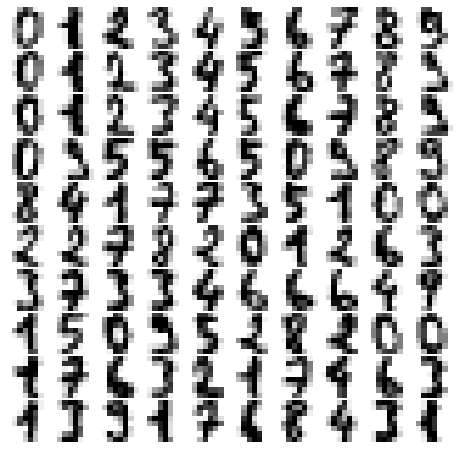

In [87]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
    subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

GMMs can have difficulty converging in such a high dimensional
space, so we will start with an invertible dimensionality reduction algorithm on
the data. Here we will use a straightforward PCA, asking it to preserve 99% of the
variance in the projected data

In [90]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

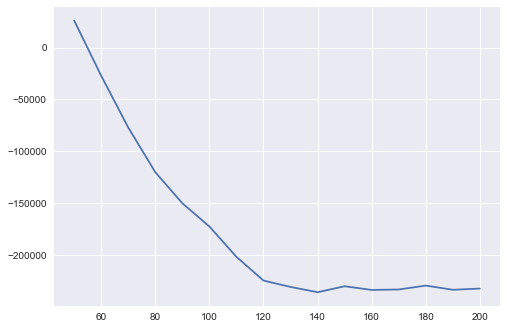

In [93]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
            for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [95]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected
space, using the GMM as a generative model:

In [97]:
data_newX, _ = gmm.sample(100)
data_newX.shape

(100, 41)

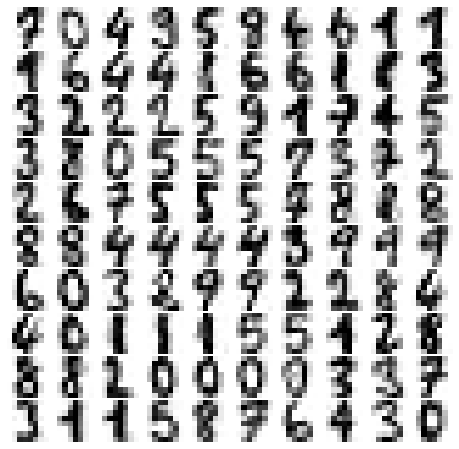

In [98]:
digits_new = pca.inverse_transform(data_newX)
plot_digits(digits_new)